In [26]:
import os
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict, namedtuple
from io import StringIO
import re
from IPython.display import display, Latex

## reading results

In [27]:
def get_results(res_path, section_name):
    # group file names by configuration
    results_by_specs = defaultdict(list)
    for fname in os.listdir(res_path):
        if not fname.endswith('.txt'):
            continue

        try:
            spec, day, hour = fname[:-len('.txt')].split('-')
            
            if 'MOSTEstimator' in fname:
                _, model, most = spec.split('_')
                features = 'zL'
            else:
                _, model, features, trend, most = spec.split('_')
        except:
            print('bad name:', fname)
            continue

        results_by_specs[(model, features, trend, most)].append(fname)
    
    # for each config, find and parse most recent result file
    df_rows, df_cols = [], None
    for spec, files in results_by_specs.items():
        res_file, res_lines, found = list(sorted(files))[-1], [], False
        with open(os.path.join(res_path, res_file)) as f:
            for i, row in enumerate(f):
                rr = row.strip()
                
                if found and not rr.startswith('**'):
                    res_lines.append(rr)
                elif found and rr.startswith('**'):
                    break
                elif not found and rr.startswith('**' + section_name):
                    found = True
        
        if not found:
            raise RuntimeError('section %s not found in file %s' % (section_name, res_file))
        elif not res_lines:
            raise RuntimeError('section %s is empty in file %s' % (section_name, res_file))

        csv_text = re.sub('[ \t]+', ',', '\n'.join(res_lines))
        section_df = pd.read_csv(StringIO(csv_text))
        for col in section_df:
            for i, val in enumerate(section_df[col]):
                df_rows.append(list(spec) + [i, col, val])

        if df_cols is None:
            df_cols = [
                'estimator', 'features', 'trend', 'most', 'trial', 'column', 'value'
            ]

    results = pd.DataFrame(df_rows, columns=df_cols)
    return results


res = get_results('dev/results', 'raw scores').replace({
    'estimator': {
        'KNeighborsRegressor': 'kNN',
        'GradientBoostingRegressor': 'GB'
    }
})
res.head(5)

,estimator,features,trend,most,trial,column,value
0,GB,f1,notrend,most,0,explained_variance_score,0.662766
1,GB,f1,notrend,most,1,explained_variance_score,0.742311
2,GB,f1,notrend,most,2,explained_variance_score,0.778146
3,GB,f1,notrend,most,3,explained_variance_score,0.754339
4,GB,f1,notrend,most,4,explained_variance_score,0.784047


In [28]:
paras = get_results('dev/results', 'raw parameters')
paras.head(5)

,estimator,features,trend,most,trial,column,value
0,GradientBoostingRegressor,f1,notrend,most,0,alpha,0.264228
1,GradientBoostingRegressor,f1,notrend,most,1,alpha,0.309997
2,GradientBoostingRegressor,f1,notrend,most,2,alpha,0.269739
3,GradientBoostingRegressor,f1,notrend,most,3,alpha,0.523821
4,GradientBoostingRegressor,f1,notrend,most,4,alpha,0.532573


## generation of charts

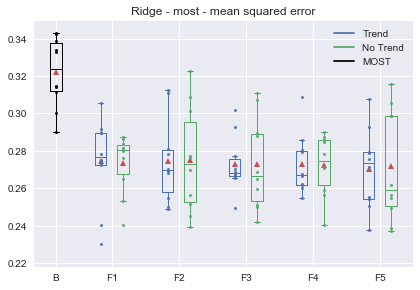

In [29]:
def paint_boxplot(bplot, all_color=None, **kwargs):
    # use all_color to paing all elements of the same color
    # or specify color for each element in kwargs
    # kwargs take precedence over all_color
    #
    # NB available elements are
    # boxes, medians, whiskers, caps, fliers, means

    for key in bplot:
        color = kwargs.get(key, all_color)
        if color:
            for element in bplot[key]:
                element.set_color(color)


def make_base_plot(res, estimator, most, column, save_path=None, plot_all=True,
                   show_legend=True, show_baseline=True):
    
    most = 'most' if most else 'nomost'
    plot_data, found = [], False
    fig, ax = plt.subplots()

    for features in range(1, 6):
        for tidx, trend in enumerate(['trend', 'notrend']):
            vals = res[
                (res.estimator == estimator) &
                (res.most == most) &
                (res.features == 'f%d' % features) &
                (res.trend == trend) & 
                (res.column == column)
            ]['value'].values
            
            if vals.size == 0:
                plot_data.append([])
                continue

            if plot_all:
                plt.scatter([3 * (features - 1) + tidx] * len(vals), vals,
                            color='C%d' % tidx, s=7, zorder=10, marker='o')

            plot_data.append(vals)
            found = True

    if not found:
        print('no results for estimator %s on %s %s' % (
            column, estimator, most
        ))
        return None, None
    
    boxplot_kwargs = {
        'showmeans': True,
        'patch_artist': False,
        'zorder': 5,
        'showfliers': not plot_all,
    }
    
    # trend
    bp1 = ax.boxplot(plot_data[::2], positions=range(0, 15, 3),
                     sym='C0.', **boxplot_kwargs)
    paint_boxplot(bp1, 'C0')

    # no trend
    bp2 = ax.boxplot(plot_data[1::2], positions=range(1, 15, 3),
                     sym='C1.', **boxplot_kwargs)
    paint_boxplot(bp2, 'C1')

    if show_baseline:
        most_data = res[
            (res.estimator == 'MOSTEstimator') &
            (res.most == most) &
            (res.column == column)
        ]

        bpm = ax.boxplot(most_data.value, positions=[-2], sym='k.',
                         widths=[0.5], **boxplot_kwargs)
        paint_boxplot(bpm, 'k')
        
        if plot_all:
            plt.scatter([-2] * len(most_data), most_data.value,
                        color='k', s=7, zorder=10, marker='o')

    if show_legend:
        old_ylim = ax.get_ylim()
        legend_lines = [
            ax.plot([], [], c='C0')[0],
            ax.plot([], [], c='C1')[0],
            ax.plot([], [], c='k')[0],
        ]
        
        ax.legend(legend_lines, ['Trend', 'No Trend', 'MOST'])
        ax.set_ylim(old_ylim)
    
    ax.margins(y=0.05)
    ax.set_xlim(-3, 14)
    ax.set_xticks([-2, 0.5, 3.5, 6.5, 9.5, 12.5])
    ax.set_xticklabels(['B', 'F1', 'F2', 'F3', 'F4', 'F5'])    
    fig.tight_layout()
    
    if save_path is not None:
        fig.savefig(os.path.join(
            save_path, 'result_%s_%s_%s.png' % (estimator, most, column)
        ))
    
    # show the title on the notebook but not in the saved figure
    ax.set_title(
        estimator +
        ' - ' + '%smost' % ('' if most else 'no ') +
        ' - ' + column.replace('_', ' ')
    )

    return fig, ax


plt.show(make_base_plot(res, 'Ridge', True, 'mean_squared_error')[0])

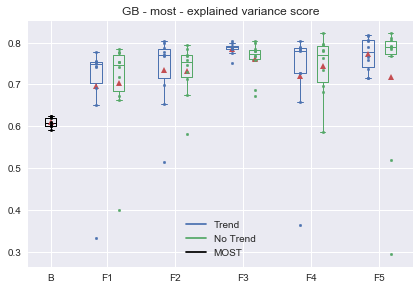

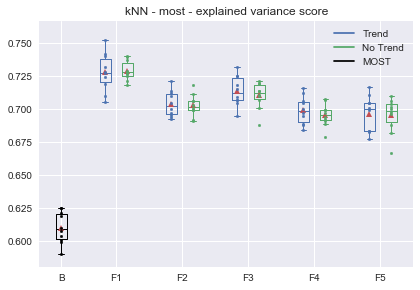

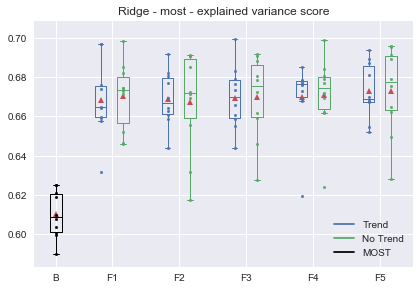

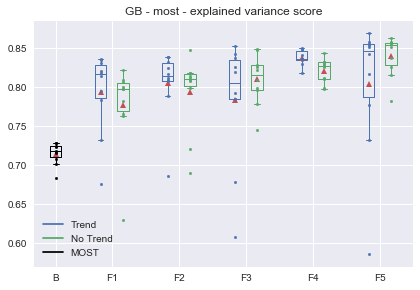

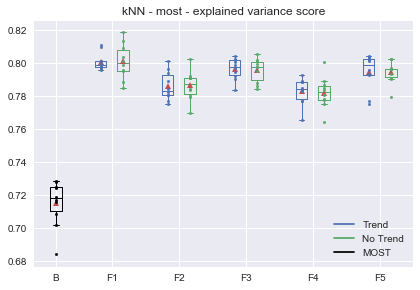

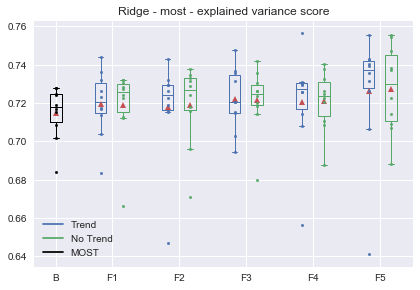

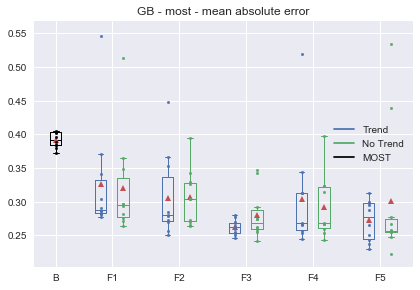

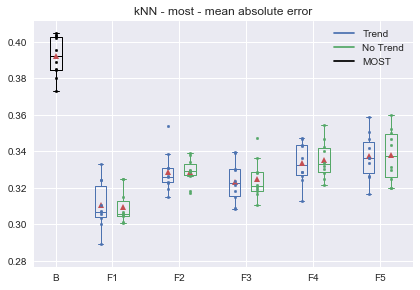

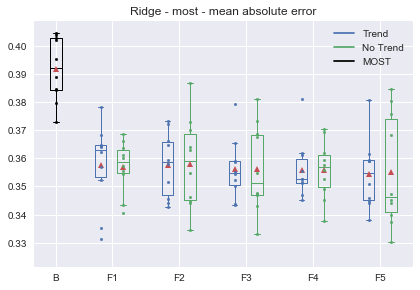

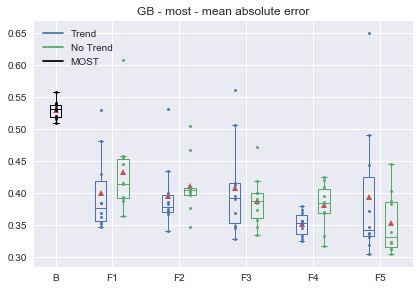

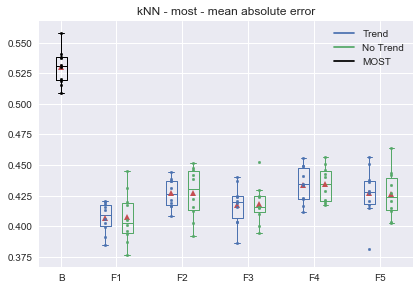

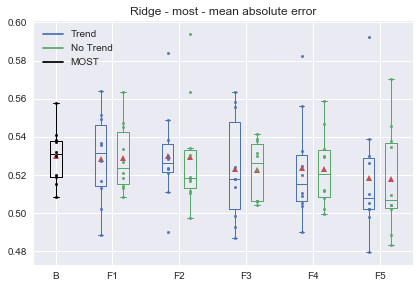

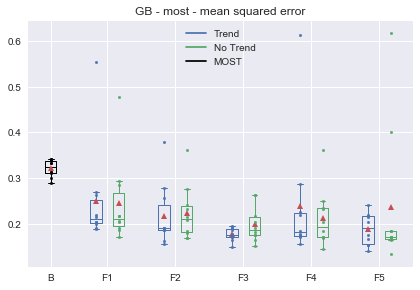

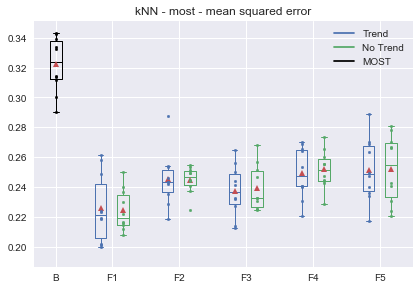

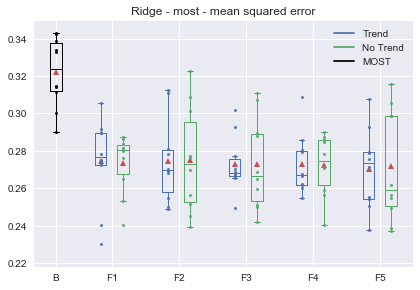

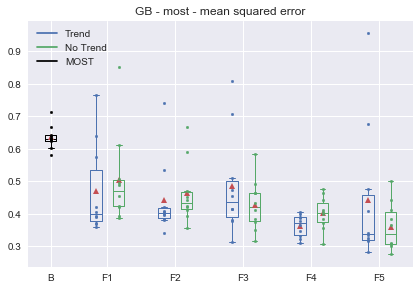

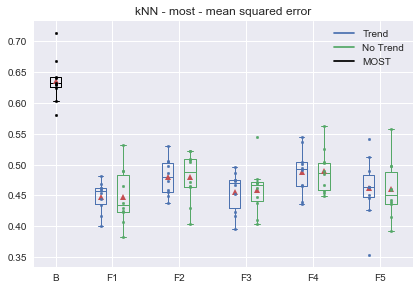

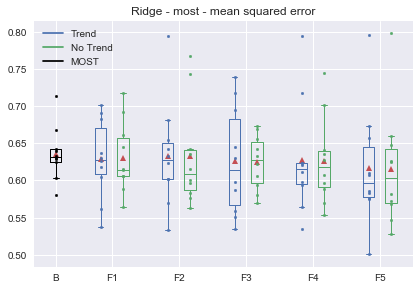

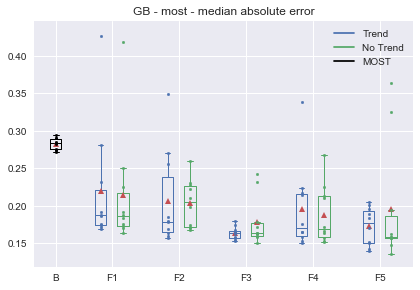

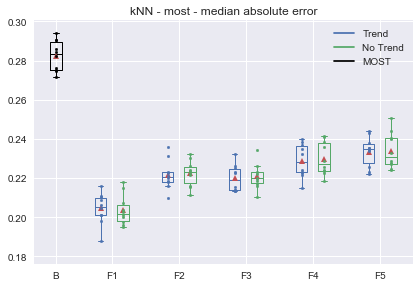

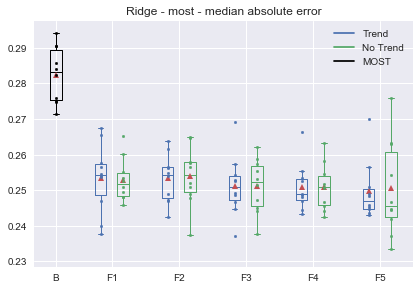

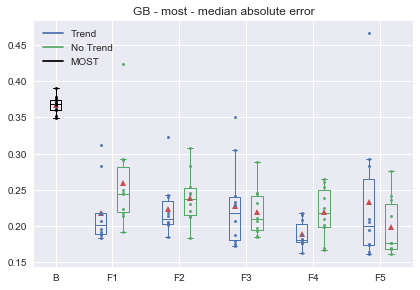

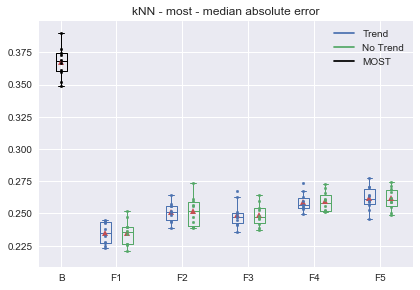

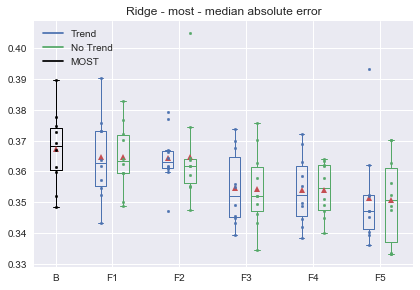

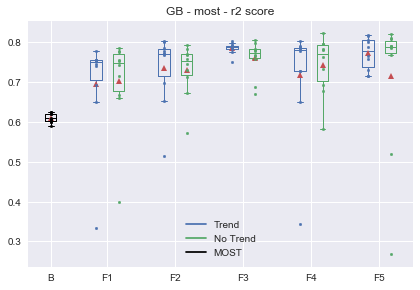

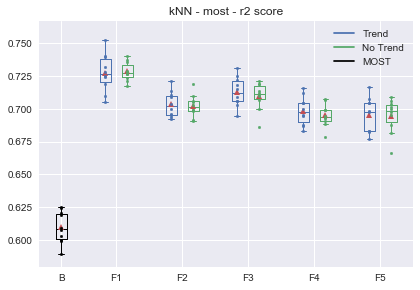

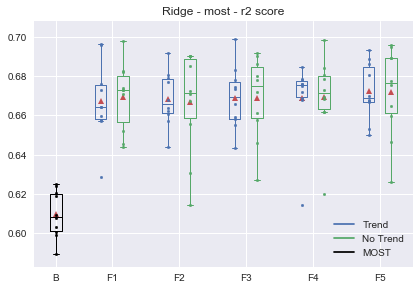

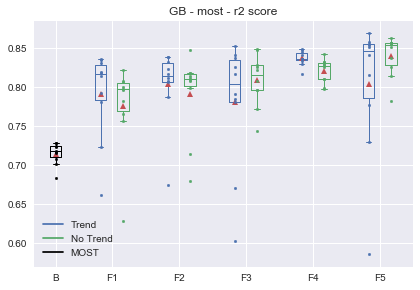

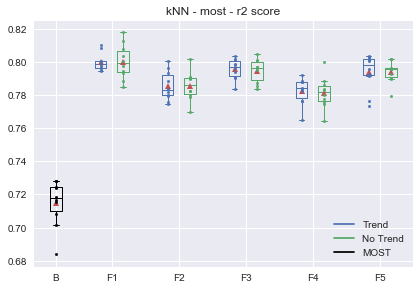

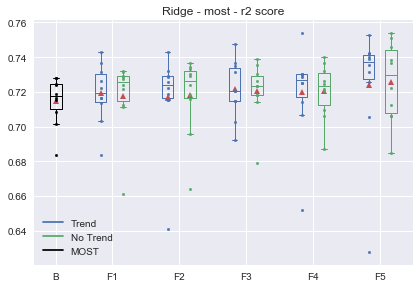

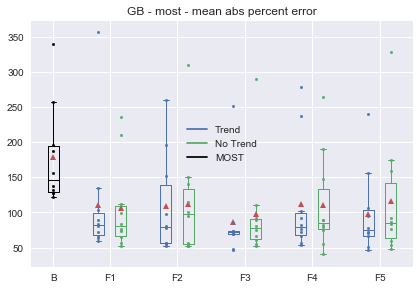

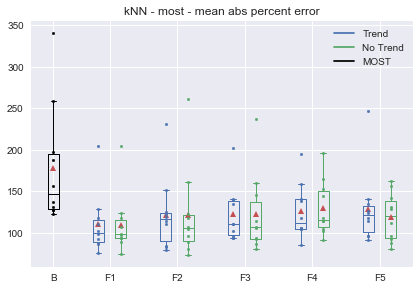

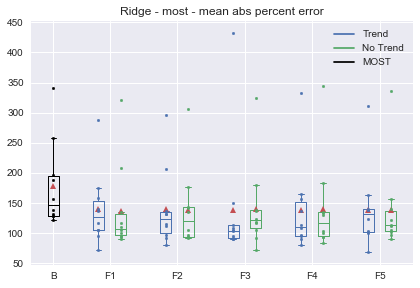

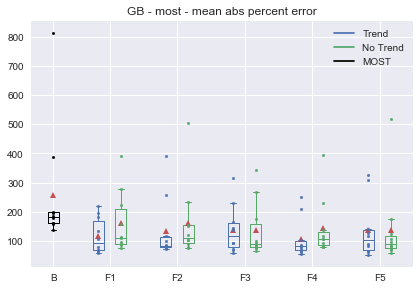

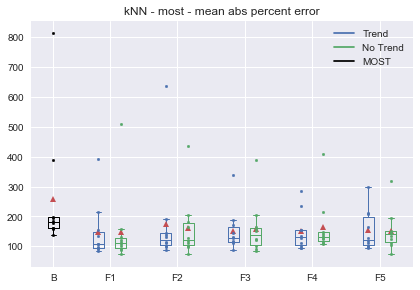

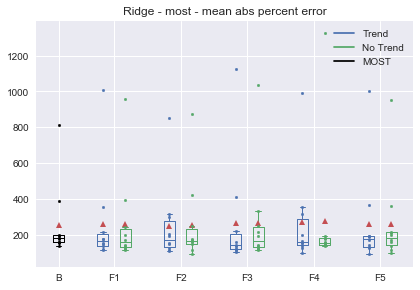

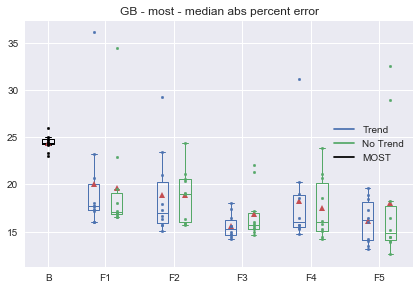

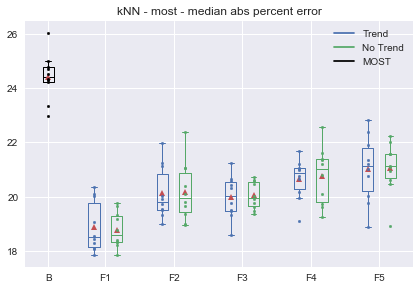

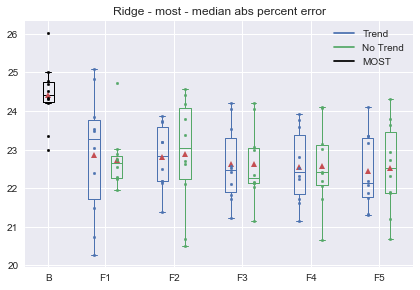

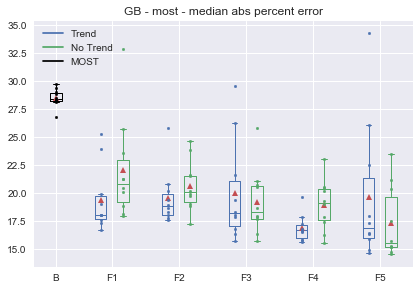

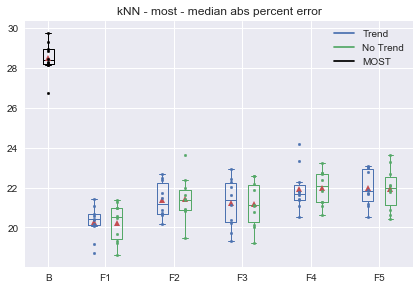

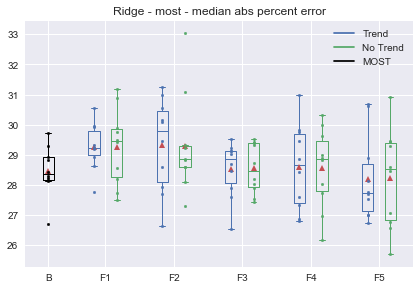

no results for estimator train_mse on GB most


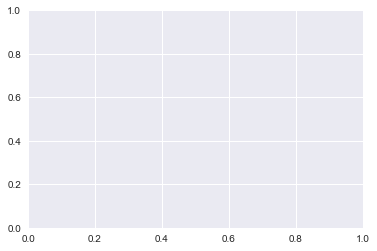

no results for estimator train_mse on kNN most


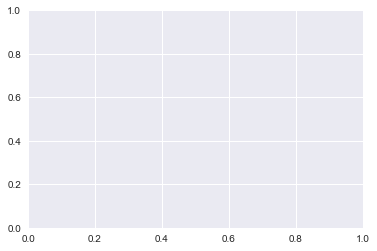

no results for estimator train_mse on Ridge most


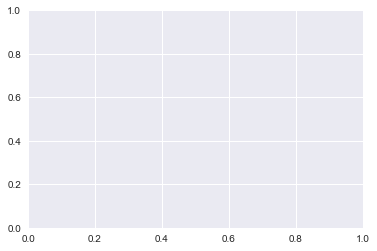

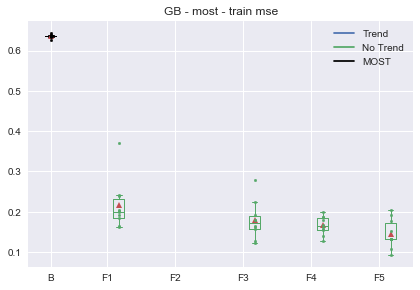

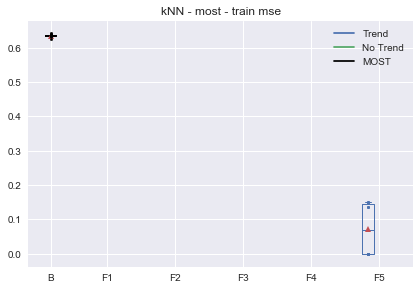

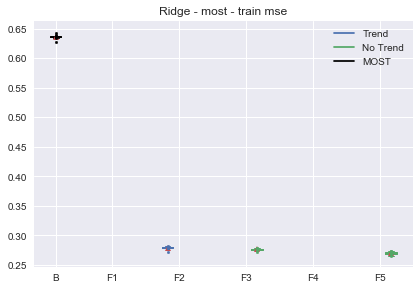

In [30]:
for met in res.column.unique():
    for most in [True, False]:
        for est in res.estimator.unique():
            if est != 'MOSTEstimator':
                plt.show(make_base_plot(res, est, most, met, 'manuscript/images')[0])

check if outliers all happened in the same outer folds

In [31]:
res[
    (res.column == 'mean_squared_error')
].groupby(['estimator', 'features', 'trend']).apply(
    lambda g: g.loc[g.value.idxmax()]
)[['trial', 'value']]

trial     value
estimator     features trend                   
GB            f1       notrend  9      0.851099
                       trend    2      0.766394
              f2       notrend  0      0.667462
                       trend    8      0.742154
              f3       notrend  6      0.583402
                       trend    6      0.809069
              f4       notrend  4      0.475039
                       trend    3      0.613572
              f5       notrend  8      0.616439
                       trend    2      0.956152
MOSTEstimator zL       trend    7      0.713057
Ridge         f1       notrend  6      0.717428
                       trend    3      0.700960
              f2       notrend  2      0.767105
                       trend    2      0.794790
              f3       notrend  8      0.672638
                       trend    7      0.739762
              f4       notrend  6      0.745151
                       trend    9      0.794517
              f5       notrend  3      0.797766
                       trend    6      0.795682
kNN           f1       notrend  9      0.532414
                       trend    0      0.480932
              f2       notrend  2      0.521940
                       trend    6      0.529899
              f3       notrend  7      0.544023
                       trend    9      0.495498
              f4       notrend  5      0.562802
                       trend    1      0.544751
              f5       notrend  6      0.558398
                       trend    2      0.541876

## preparations for export 

In [32]:
# rename stuff
renamed = res[
    (res.column != 'explained_variance_score')
].replace({
    'most': {'most': 'Y', 'nomost': 'N'},
    'trend': {'trend': 'Y', 'notrend': 'N'},
    'column': {
        'mean_squared_error': 'MSE',
        'median_squared_error': 'mSE',
        'mean_absolute_error': 'MAE',
        'median_absolute_error': 'mAE',
        'mean_abs_percent_error': 'MAPE',
        'median_abs_percent_error': 'mAPE',
        'r2_score': '$R^2$',
    },
    'features': {'f1': 'F1', 'f2': 'F2', 'f3': 'F3', 'f4': 'F4', 'f5': 'F5'},
}).rename(columns={
    'features': 'Features',
    'column': 'Metric',
    'trend': 'Trend',
    'most': 'MOST',
    'estimator': 'Estimator',
})

In [33]:
renamed.head()

,Estimator,Features,Trend,MOST,trial,Metric,value
10,GB,F1,N,Y,0,MAE,0.365464
11,GB,F1,N,Y,1,MAE,0.293666
12,GB,F1,N,Y,2,MAE,0.271148
13,GB,F1,N,Y,3,MAE,0.282079
14,GB,F1,N,Y,4,MAE,0.264342


In [34]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


def table_newline(text):
    return '\makecell[c]{%s}' % text.replace('\n', r'\\')


def df_to_latex(df, vertical_space='1ex', column_align='c', fill_page_width=True,
                save_to=None, clear_index_name=True):
    
    if clear_index_name:  # otherwise first row will be included in the table header
        df.index.name = ''

    if len(column_align) == 1:
        column_align = column_align * len(df.columns)

    latex = '\\centering' + df.to_latex(
        escape=False,
        bold_rows=True,
        column_format='asd' if fill_page_width else column_align,
        multirow=True,
        #index_names=not clear_index_name,
    )

    # replace double clines with a single hline
    latex = re.sub(r'\\cline{.*?}\n\\cline{.*?}', '\hline', latex)

    if vertical_space:
        # add vertical space between cells
        latex = (
            '\setcellgapes{%s}\makegapedcells' % vertical_space
        ) + latex

    if 'makecell' in latex:
        # if we used makecell to insert newlines inside each cell, we have
        # to double the vertical size of the multirows
        # also move column name slightly upwards to make it aligned with center line
        # (move up by 1ex and down by 0.15ex to balance the padding)
        latex = re.sub(r'\\multirow{(\d+)}{\*}{(.*?)}', 
                       lambda m: r'\multirowcell{%d}[0.75ex][c]{%s}' % (2 * int(m[1]), m[2]),
                       latex)

    if fill_page_width:
        # use tabular* environment to make table fill the page width
        latex = latex.replace(
            r'\begin{tabular}{asd}',
            r'\begin{tabular*}{\textwidth}{%s @{\extracolsep{\fill}} %s}' % (
                column_align[0], column_align[1:]
            )
        ).replace(r'\end{tabular}', r'\end{tabular*}')
    
    if save_to:
        with open(save_to, 'w') as f:
            f.write(latex)

    return latex

## generation of effect sizes

compare each feature set with the most baseline (choose the best between trend/no trend). positive effect size means the estimator is better

In [35]:
most_data = renamed[
    (renamed.Metric == 'MSE') &
    (renamed.Estimator == 'MOSTEstimator')
]


def get_best_trend_notrend(scores):
    ''' returns the trend which gives the lowest average scores
        for a single estimator and feature set
    '''
    assert len(scores.Features.unique()) == 1
    assert len(scores.Estimator.unique()) == 1

    trend_data = scores[scores.Trend == 'Y'].value.values
    trend_mean = trend_data.mean()
    
    notrend_data = scores[scores.Trend == 'N'].value.values
    notrend_mean = notrend_data.mean()
    
    return trend_data if trend_mean < notrend_mean else notrend_data


def compute_effect_size(sample1, sample2, ci_alpha=0.95):
    # https://stats.stackexchange.com/a/247011/141343
    
    n1, n2 = len(sample1), len(sample2)
    m1, m2 = sample1.mean(), sample2.mean()
    s1, s2 = sample1.std(), sample2.std()

    std = np.sqrt((s1**2 + s2**2) / 2)
    es = (m2 - m1) / std
    
    es_var = (
        es**2 / (8 * std**4) * (
            s1**4 / (n1 - 1) + s2**4 / (n2 - 1)
        ) +
        s1**2 / (std**2 * (n1 - 1)) +
        s2**2 / (std**2 * (n2 - 1))
    )
    
    if ci_alpha:
        assert 0 < ci_alpha < 1
        ci_lo, ci_hi = stats.norm.interval(ci_alpha)
        ci = (  # ci_lo is already negative
            es + ci_lo * np.sqrt(es_var),
            es + ci_hi * np.sqrt(es_var),
        )
    else:
        ci = None
    
    return es, es_var, ci


def compare_with_most(scores):
    assert len(scores.MOST.unique()) == 1
    
    most = scores.MOST.values[0]
    most_most = most_data[most_data.MOST == most].value
    
    data_best = get_best_trend_notrend(scores)
    ci, _, (es_ci_lo, es_ci_hi) = compute_effect_size(data_best, most_most)
    
    return pd.Series([
        table_newline('%.2f\n(%.2f; %.2f)' % (ci, es_ci_lo, es_ci_hi))
    ], index=['es'])


baseline_comparison = renamed[
    (renamed.Metric == 'MSE') &
    (renamed.Estimator != 'MOSTEstimator')
].groupby(
    ['Estimator', 'MOST', 'Features']
).apply(compare_with_most).pivot_table(
    columns='Features',
    values='es',
    index=['MOST', 'Estimator'],
    aggfunc=lambda ci: ci[0],
)


df_to_latex(baseline_comparison, column_align='lc|ccccc', clear_index_name=False,
            save_to='manuscript/include/baseline_comparison.tex')

baseline_comparison

Features                                       F1  \
MOST Estimator                                      
N    GB         \makecell[c]{1.71\\(0.53; 2.89)}    
     Ridge      \makecell[c]{0.17\\(-0.76; 1.09)}   
     kNN        \makecell[c]{4.77\\(2.93; 6.60)}    
Y    GB         \makecell[c]{1.23\\(0.16; 2.31)}    
     Ridge      \makecell[c]{2.90\\(1.56; 4.24)}    
     kNN        \makecell[c]{6.05\\(3.78; 8.33)}    

Features                                       F2  \
MOST Estimator                                      
N    GB         \makecell[c]{2.37\\(1.01; 3.73)}    
     Ridge      \makecell[c]{0.07\\(-0.85; 1.00)}   
     kNN        \makecell[c]{4.22\\(2.56; 5.88)}    
Y    GB         \makecell[c]{2.19\\(0.87; 3.50)}    
     Ridge      \makecell[c]{2.39\\(1.18; 3.60)}    
     kNN        \makecell[c]{5.34\\(3.06; 7.62)}    

Features                                       F3  \
MOST Estimator                                      
N    GB         \makecell[c]{3.61\\(1.95; 5.28)}    
     Ridge      \makecell[c]{0.34\\(-0.59; 1.27)}   
     kNN        \makecell[c]{5.35\\(3.36; 7.34)}    
Y    GB         \makecell[c]{8.87\\(5.71; 12.02)}   
     Ridge      \makecell[c]{3.01\\(1.63; 4.38)}    
     kNN        \makecell[c]{4.84\\(3.00; 6.69)}    

Features                                       F4  \
MOST Estimator                                      
N    GB         \makecell[c]{8.06\\(5.26; 10.87)}   
     Ridge      \makecell[c]{0.21\\(-0.72; 1.13)}   
     kNN        \makecell[c]{4.21\\(2.55; 5.86)}    
Y    GB         \makecell[c]{2.50\\(1.09; 3.90)}    
     Ridge      \makecell[c]{2.92\\(1.58; 4.26)}    
     kNN        \makecell[c]{4.13\\(2.49; 5.78)}    

Features                                       F5  
MOST Estimator                                     
N    GB         \makecell[c]{4.98\\(2.88; 7.08)}   
     Ridge      \makecell[c]{0.36\\(-0.57; 1.30)}  
     kNN        \makecell[c]{4.33\\(2.61; 6.05)}   
Y    GB         \makecell[c]{4.94\\(2.90; 6.99)}   
     Ridge      \makecell[c]{2.67\\(1.40; 3.94)}   
     kNN        \makecell[c]{3.63\\(2.13; 5.14)}

compute performance change from $F_i$ to $F_{i+1}$ (choosing the best between trend/no trend), positive effect size means improvement

In [36]:
def compare_feature_sets(scores):
    feature_sets = list(sorted(scores.Features.unique()))

    effect_sizes = []
    for f1, f2 in zip(feature_sets[1:], feature_sets[:-1]):
        f1_data = get_best_trend_notrend(scores[scores.Features == f1])
        f2_data = get_best_trend_notrend(scores[scores.Features == f2])
        
        ci, _, (es_ci_lo, es_ci_hi) = compute_effect_size(f1_data, f2_data)
        
        ci_str = table_newline('%.2f\n(%.2f; %.2f)' % (ci, es_ci_lo, es_ci_hi))
        effect_sizes.append(ci_str)

    return pd.Series(effect_sizes, index=['F%d' % f for f in range(2, 6)])


fset_comparison = renamed[
    (renamed.Metric == 'MSE') &
    (renamed.Estimator != 'MOSTEstimator')
].groupby(['MOST', 'Estimator']).apply(compare_feature_sets)

df_to_latex(fset_comparison, column_align='cc|cccc', clear_index_name=False,
            save_to='manuscript/include/fset_comparison.tex')

fset_comparison

F2  \
MOST Estimator                                        
N    GB         \makecell[c]{0.23\\(-0.70; 1.16)}     
     Ridge      \makecell[c]{-0.06\\(-0.98; 0.87)}    
     kNN        \makecell[c]{-0.78\\(-1.74; 0.18)}    
Y    GB         \makecell[c]{0.35\\(-0.58; 1.28)}     
     Ridge      \makecell[c]{-0.05\\(-0.97; 0.87)}    
     kNN        \makecell[c]{-1.83\\(-2.96; -0.71)}   

                                               F3  \
MOST Estimator                                      
N    GB         \makecell[c]{0.14\\(-0.78; 1.07)}   
     Ridge      \makecell[c]{0.15\\(-0.77; 1.08)}   
     kNN        \makecell[c]{0.68\\(-0.27; 1.64)}   
Y    GB         \makecell[c]{0.88\\(-0.13; 1.88)}   
     Ridge      \makecell[c]{0.09\\(-0.83; 1.02)}   
     kNN        \makecell[c]{0.57\\(-0.38; 1.52)}   

                                                F4  \
MOST Estimator                                       
N    GB         \makecell[c]{1.13\\(0.10; 2.15)}     
     Ridge      \makecell[c]{-0.05\\(-0.97; 0.88)}   
     kNN        \makecell[c]{-0.97\\(-1.95; 0.01)}   
Y    GB         \makecell[c]{-0.82\\(-1.81; 0.17)}   
     Ridge      \makecell[c]{0.02\\(-0.90; 0.94)}    
     kNN        \makecell[c]{-0.73\\(-1.68; 0.23)}   

                                                F5  
MOST Estimator                                      
N    GB         \makecell[c]{0.06\\(-0.87; 0.98)}   
     Ridge      \makecell[c]{0.17\\(-0.75; 1.10)}   
     kNN        \makecell[c]{0.70\\(-0.25; 1.65)}   
Y    GB         \makecell[c]{0.49\\(-0.45; 1.43)}   
     Ridge      \makecell[c]{0.11\\(-0.81; 1.04)}   
     kNN        \makecell[c]{-0.12\\(-1.04; 0.81)}

compute performance change between trend/no trend, for the same estimator/most/features. positive means trend is better

In [37]:
def compare_trend_notrend(scores):
    trend_data = scores[scores.Trend == 'Y'].value
    notrend_data = scores[scores.Trend == 'N'].value

    ci, _, (es_ci_lo, es_ci_hi) = compute_effect_size(trend_data, notrend_data)
    
    return pd.Series([
        table_newline('%.2f\n(%.2f; %.2f)' % (ci, es_ci_lo, es_ci_hi))
    ], index=['es'])
    
    
    return pd.Series([es_ci], index=['es_ci'])


trend_comparison = renamed[
    (renamed.Metric == 'MSE') &
    (renamed.Estimator != 'MOSTEstimator')
].groupby(
    ['Estimator', 'MOST', 'Features']
).apply(compare_trend_notrend).reset_index().pivot_table(
    columns='Features',
    values='es',
    index=['MOST', 'Estimator'],
    aggfunc=lambda ci: ci.values[0]
)


df_to_latex(trend_comparison, column_align='lc|ccccc', clear_index_name=False,
            save_to='manuscript/include/trend_comparison.tex')

trend_comparison

Features                                        F1  \
MOST Estimator                                       
N    GB         \makecell[c]{0.24\\(-0.68; 1.17)}    
     Ridge      \makecell[c]{0.04\\(-0.89; 0.96)}    
     kNN        \makecell[c]{-0.01\\(-0.93; 0.92)}   
Y    GB         \makecell[c]{-0.06\\(-0.99; 0.86)}   
     Ridge      \makecell[c]{-0.05\\(-0.98; 0.87)}   
     kNN        \makecell[c]{-0.06\\(-0.98; 0.87)}   

Features                                        F2  \
MOST Estimator                                       
N    GB         \makecell[c]{0.21\\(-0.72; 1.13)}    
     Ridge      \makecell[c]{-0.02\\(-0.94; 0.91)}   
     kNN        \makecell[c]{-0.00\\(-0.93; 0.92)}   
Y    GB         \makecell[c]{0.09\\(-0.84; 1.01)}    
     Ridge      \makecell[c]{0.02\\(-0.91; 0.94)}    
     kNN        \makecell[c]{-0.02\\(-0.94; 0.91)}   

Features                                        F3  \
MOST Estimator                                       
N    GB         \makecell[c]{-0.48\\(-1.42; 0.47)}   
     Ridge      \makecell[c]{-0.02\\(-0.95; 0.90)}   
     kNN        \makecell[c]{0.10\\(-0.83; 1.02)}    
Y    GB         \makecell[c]{0.76\\(-0.22; 1.73)}    
     Ridge      \makecell[c]{0.02\\(-0.90; 0.94)}    
     kNN        \makecell[c]{0.12\\(-0.81; 1.04)}    

Features                                        F4  \
MOST Estimator                                       
N    GB         \makecell[c]{0.89\\(-0.09; 1.86)}    
     Ridge      \makecell[c]{-0.02\\(-0.95; 0.90)}   
     kNN        \makecell[c]{0.04\\(-0.89; 0.96)}    
Y    GB         \makecell[c]{-0.24\\(-1.17; 0.68)}   
     Ridge      \makecell[c]{-0.02\\(-0.94; 0.90)}   
     kNN        \makecell[c]{0.15\\(-0.77; 1.08)}    

Features                                        F5  
MOST Estimator                                      
N    GB         \makecell[c]{-0.52\\(-1.47; 0.43)}  
     Ridge      \makecell[c]{-0.01\\(-0.94; 0.91)}  
     kNN        \makecell[c]{-0.03\\(-0.95; 0.89)}  
Y    GB         \makecell[c]{0.43\\(-0.51; 1.38)}   
     Ridge      \makecell[c]{0.05\\(-0.87; 0.97)}   
     kNN        \makecell[c]{0.02\\(-0.90; 0.94)}

## generation of result tables

In [38]:
most_est_results = renamed[
    (renamed.Estimator == 'MOSTEstimator')
].replace({
    'MOST': {'Y': 'MOST', 'N': 'All'}
}).pivot_table(
    columns='MOST',
    index='Metric',
    values='value',
    aggfunc=lambda g: '%.2f (%.2f)' % (g.mean(), g.std())
).reindex([  # change order of columns
    'MSE', '$R^2$', 'MAE', 'mAE', 'MAPE', 'mAPE'
])

df_to_latex(most_est_results, column_align='l|rr', fill_page_width=False, vertical_space=None,
            save_to='manuscript/include/most_est_results.tex')


most_est_results

MOST,All,MOST
,,
MSE,0.64 (0.04),0.32 (0.02)
$R^2$,0.71 (0.01),0.61 (0.01)
MAE,0.53 (0.01),0.39 (0.01)
mAE,0.37 (0.01),0.28 (0.01)
MAPE,257.80 (207.39),178.68 (71.19)
mAPE,28.48 (0.81),24.42 (0.84)


In [39]:
# for now we dont have nomost results, so we just copy the most ones
# so that we can preview how the tables will look like once they are complete
all_most = {'most', 'nomost'}
missing = all_most - set(res.most)
if missing:
    print('*** WARNING')
    print('replacing missing values in %s with fake measures' % missing)
    allres, missing = [], list(missing)[0]
    for row in res.values:
        allres.append(row)
        newrow = [x for x in row]
        newrow[3] = missing
        allres.append(newrow)
    allres = pd.DataFrame(allres, columns=res.columns)
else:
    allres = res

In [40]:
# one table for each estimator
for estimator in renamed.Estimator.unique():
    if estimator == 'MOSTEstimator':
        continue

    est_res = renamed[
        (renamed.Estimator == estimator)
    ].pivot_table(
        columns='Features',
        values='value',
        index=['Metric', 'MOST', 'Trend'],
        aggfunc=lambda vals: table_newline('%.2f\n(%.2f)' % (vals.mean(), vals.std()))
    ).reindex([  # change order of columns
        'MSE', '$R^2$', 'MAE', 'mAE', 'MAPE', 'mAPE'
    ], level=0)
    
    display(est_res)
    
    lll = df_to_latex(est_res, vertical_space='0.15ex', column_align='lcc|ccccc',
                save_to='manuscript/include/results_%s.tex' % estimator)

Features                                       F1  \
Metric MOST Trend                                   
MSE    N    N      \makecell[c]{0.50\\(0.14)}       
            Y      \makecell[c]{0.47\\(0.14)}       
       Y    N      \makecell[c]{0.25\\(0.09)}       
            Y      \makecell[c]{0.25\\(0.11)}       
$R^2$  N    N      \makecell[c]{0.78\\(0.06)}       
            Y      \makecell[c]{0.79\\(0.06)}       
       Y    N      \makecell[c]{0.70\\(0.12)}       
            Y      \makecell[c]{0.70\\(0.13)}       
MAE    N    N      \makecell[c]{0.43\\(0.07)}       
            Y      \makecell[c]{0.40\\(0.06)}       
       Y    N      \makecell[c]{0.32\\(0.08)}       
            Y      \makecell[c]{0.33\\(0.08)}       
mAE    N    N      \makecell[c]{0.26\\(0.07)}       
            Y      \makecell[c]{0.22\\(0.04)}       
       Y    N      \makecell[c]{0.21\\(0.08)}       
            Y      \makecell[c]{0.22\\(0.08)}       
MAPE   N    N      \makecell[c]{162.52\\(104.39)}   
            Y      \makecell[c]{118.51\\(60.72)}    
       Y    N      \makecell[c]{106.73\\(64.65)}    
            Y      \makecell[c]{111.10\\(89.45)}    
mAPE   N    N      \makecell[c]{21.98\\(4.51)}      
            Y      \makecell[c]{19.33\\(2.90)}      
       Y    N      \makecell[c]{19.59\\(5.58)}      
            Y      \makecell[c]{20.04\\(6.06)}      

Features                                       F2  \
Metric MOST Trend                                   
MSE    N    N      \makecell[c]{0.46\\(0.09)}       
            Y      \makecell[c]{0.44\\(0.12)}       
       Y    N      \makecell[c]{0.22\\(0.06)}       
            Y      \makecell[c]{0.22\\(0.07)}       
$R^2$  N    N      \makecell[c]{0.79\\(0.05)}       
            Y      \makecell[c]{0.80\\(0.05)}       
       Y    N      \makecell[c]{0.73\\(0.07)}       
            Y      \makecell[c]{0.73\\(0.09)}       
MAE    N    N      \makecell[c]{0.41\\(0.04)}       
            Y      \makecell[c]{0.40\\(0.05)}       
       Y    N      \makecell[c]{0.31\\(0.04)}       
            Y      \makecell[c]{0.31\\(0.06)}       
mAE    N    N      \makecell[c]{0.24\\(0.04)}       
            Y      \makecell[c]{0.22\\(0.04)}       
       Y    N      \makecell[c]{0.20\\(0.03)}       
            Y      \makecell[c]{0.21\\(0.06)}       
MAPE   N    N      \makecell[c]{161.47\\(128.93)}   
            Y      \makecell[c]{134.46\\(106.10)}   
       Y    N      \makecell[c]{112.76\\(78.44)}    
            Y      \makecell[c]{108.63\\(71.50)}    
mAPE   N    N      \makecell[c]{20.60\\(2.29)}      
            Y      \makecell[c]{19.49\\(2.43)}      
       Y    N      \makecell[c]{18.84\\(2.90)}      
            Y      \makecell[c]{18.85\\(4.49)}      

Features                                      F3  \
Metric MOST Trend                                  
MSE    N    N      \makecell[c]{0.43\\(0.08)}      
            Y      \makecell[c]{0.49\\(0.16)}      
       Y    N      \makecell[c]{0.20\\(0.04)}      
            Y      \makecell[c]{0.18\\(0.01)}      
$R^2$  N    N      \makecell[c]{0.81\\(0.03)}      
            Y      \makecell[c]{0.78\\(0.08)}      
       Y    N      \makecell[c]{0.76\\(0.05)}      
            Y      \makecell[c]{0.79\\(0.01)}      
MAE    N    N      \makecell[c]{0.39\\(0.04)}      
            Y      \makecell[c]{0.41\\(0.07)}      
       Y    N      \makecell[c]{0.28\\(0.04)}      
            Y      \makecell[c]{0.26\\(0.01)}      
mAE    N    N      \makecell[c]{0.22\\(0.03)}      
            Y      \makecell[c]{0.23\\(0.06)}      
       Y    N      \makecell[c]{0.18\\(0.03)}      
            Y      \makecell[c]{0.16\\(0.01)}      
MAPE   N    N      \makecell[c]{137.02\\(95.56)}   
            Y      \makecell[c]{138.86\\(82.25)}   
       Y    N      \makecell[c]{97.33\\(70.36)}    
            Y      \makecell[c]{85.95\\(59.66)}    
mAPE   N    N      \makecell[c]{19.18\\(2.93)}     
            Y      \makecell[c]{19.95\\(4.57)}

Features                                       F1  \
Metric MOST Trend                                   
MSE    N    N      \makecell[c]{0.45\\(0.05)}       
            Y      \makecell[c]{0.45\\(0.02)}       
       Y    N      \makecell[c]{0.22\\(0.01)}       
            Y      \makecell[c]{0.23\\(0.02)}       
$R^2$  N    N      \makecell[c]{0.80\\(0.01)}       
            Y      \makecell[c]{0.80\\(0.01)}       
       Y    N      \makecell[c]{0.73\\(0.01)}       
            Y      \makecell[c]{0.73\\(0.01)}       
MAE    N    N      \makecell[c]{0.41\\(0.02)}       
            Y      \makecell[c]{0.41\\(0.01)}       
       Y    N      \makecell[c]{0.31\\(0.01)}       
            Y      \makecell[c]{0.31\\(0.01)}       
mAE    N    N      \makecell[c]{0.23\\(0.01)}       
            Y      \makecell[c]{0.23\\(0.01)}       
       Y    N      \makecell[c]{0.20\\(0.01)}       
            Y      \makecell[c]{0.20\\(0.01)}       
MAPE   N    N      \makecell[c]{149.67\\(128.39)}   
            Y      \makecell[c]{147.68\\(95.02)}    
       Y    N      \makecell[c]{110.32\\(35.89)}    
            Y      \makecell[c]{110.71\\(36.57)}    
mAPE   N    N      \makecell[c]{20.25\\(0.97)}      
            Y      \makecell[c]{20.28\\(0.82)}      
       Y    N      \makecell[c]{18.79\\(0.65)}      
            Y      \makecell[c]{18.89\\(0.95)}      

Features                                       F2  \
Metric MOST Trend                                   
MSE    N    N      \makecell[c]{0.48\\(0.04)}       
            Y      \makecell[c]{0.48\\(0.03)}       
       Y    N      \makecell[c]{0.25\\(0.01)}       
            Y      \makecell[c]{0.25\\(0.02)}       
$R^2$  N    N      \makecell[c]{0.79\\(0.01)}       
            Y      \makecell[c]{0.79\\(0.01)}       
       Y    N      \makecell[c]{0.70\\(0.01)}       
            Y      \makecell[c]{0.70\\(0.01)}       
MAE    N    N      \makecell[c]{0.43\\(0.02)}       
            Y      \makecell[c]{0.43\\(0.01)}       
       Y    N      \makecell[c]{0.33\\(0.01)}       
            Y      \makecell[c]{0.33\\(0.01)}       
mAE    N    N      \makecell[c]{0.25\\(0.01)}       
            Y      \makecell[c]{0.25\\(0.01)}       
       Y    N      \makecell[c]{0.22\\(0.01)}       
            Y      \makecell[c]{0.22\\(0.01)}       
MAPE   N    N      \makecell[c]{162.01\\(104.52)}   
            Y      \makecell[c]{176.15\\(164.41)}   
       Y    N      \makecell[c]{121.57\\(54.94)}    
            Y      \makecell[c]{122.25\\(44.17)}    
mAPE   N    N      \makecell[c]{21.44\\(1.09)}      
            Y      \makecell[c]{21.38\\(0.89)}      
       Y    N      \makecell[c]{20.18\\(1.08)}      
            Y      \makecell[c]{20.14\\(0.96)}      

Features                                      F3  \
Metric MOST Trend                                  
MSE    N    N      \makecell[c]{0.46\\(0.04)}      
            Y      \makecell[c]{0.46\\(0.03)}      
       Y    N      \makecell[c]{0.24\\(0.02)}      
            Y      \makecell[c]{0.24\\(0.02)}      
$R^2$  N    N      \makecell[c]{0.79\\(0.01)}      
            Y      \makecell[c]{0.80\\(0.01)}      
       Y    N      \makecell[c]{0.71\\(0.01)}      
            Y      \makecell[c]{0.71\\(0.01)}      
MAE    N    N      \makecell[c]{0.42\\(0.02)}      
            Y      \makecell[c]{0.42\\(0.02)}      
       Y    N      \makecell[c]{0.32\\(0.01)}      
            Y      \makecell[c]{0.32\\(0.01)}      
mAE    N    N      \makecell[c]{0.25\\(0.01)}      
            Y      \makecell[c]{0.25\\(0.01)}      
       Y    N      \makecell[c]{0.22\\(0.01)}      
            Y      \makecell[c]{0.22\\(0.01)}      
MAPE   N    N      \makecell[c]{158.82\\(88.71)}   
            Y      \makecell[c]{153.01\\(71.99)}   
       Y    N      \makecell[c]{122.51\\(47.61)}   
            Y      \makecell[c]{122.75\\(33.56)}   
mAPE   N    N      \makecell[c]{21.16\\(1.15)}     
            Y      \makecell[c]{21.20\\(1.24)}

Features                                       F1  \
Metric MOST Trend                                   
MSE    N    N      \makecell[c]{0.63\\(0.05)}       
            Y      \makecell[c]{0.63\\(0.05)}       
       Y    N      \makecell[c]{0.27\\(0.02)}       
            Y      \makecell[c]{0.27\\(0.02)}       
$R^2$  N    N      \makecell[c]{0.72\\(0.02)}       
            Y      \makecell[c]{0.72\\(0.02)}       
       Y    N      \makecell[c]{0.67\\(0.02)}       
            Y      \makecell[c]{0.67\\(0.02)}       
MAE    N    N      \makecell[c]{0.53\\(0.02)}       
            Y      \makecell[c]{0.53\\(0.02)}       
       Y    N      \makecell[c]{0.36\\(0.01)}       
            Y      \makecell[c]{0.36\\(0.01)}       
mAE    N    N      \makecell[c]{0.36\\(0.01)}       
            Y      \makecell[c]{0.36\\(0.01)}       
       Y    N      \makecell[c]{0.25\\(0.01)}       
            Y      \makecell[c]{0.25\\(0.01)}       
MAPE   N    N      \makecell[c]{262.89\\(258.33)}   
            Y      \makecell[c]{262.27\\(271.17)}   
       Y    N      \makecell[c]{137.37\\(73.04)}    
            Y      \makecell[c]{139.18\\(60.62)}    
mAPE   N    N      \makecell[c]{29.27\\(1.25)}      
            Y      \makecell[c]{29.28\\(0.78)}      
       Y    N      \makecell[c]{22.74\\(0.77)}      
            Y      \makecell[c]{22.87\\(1.63)}      

Features                                       F2  \
Metric MOST Trend                                   
MSE    N    N      \makecell[c]{0.63\\(0.07)}       
            Y      \makecell[c]{0.63\\(0.07)}       
       Y    N      \makecell[c]{0.27\\(0.03)}       
            Y      \makecell[c]{0.27\\(0.02)}       
$R^2$  N    N      \makecell[c]{0.72\\(0.02)}       
            Y      \makecell[c]{0.72\\(0.03)}       
       Y    N      \makecell[c]{0.67\\(0.03)}       
            Y      \makecell[c]{0.67\\(0.01)}       
MAE    N    N      \makecell[c]{0.53\\(0.03)}       
            Y      \makecell[c]{0.53\\(0.02)}       
       Y    N      \makecell[c]{0.36\\(0.02)}       
            Y      \makecell[c]{0.36\\(0.01)}       
mAE    N    N      \makecell[c]{0.36\\(0.02)}       
            Y      \makecell[c]{0.36\\(0.01)}       
       Y    N      \makecell[c]{0.25\\(0.01)}       
            Y      \makecell[c]{0.25\\(0.01)}       
MAPE   N    N      \makecell[c]{258.83\\(235.59)}   
            Y      \makecell[c]{253.28\\(222.37)}   
       Y    N      \makecell[c]{138.23\\(65.42)}    
            Y      \makecell[c]{139.73\\(65.11)}    
mAPE   N    N      \makecell[c]{29.30\\(1.63)}      
            Y      \makecell[c]{29.34\\(1.55)}      
       Y    N      \makecell[c]{22.90\\(1.46)}      
            Y      \makecell[c]{22.81\\(0.85)}      

Features                                       F3  \
Metric MOST Trend                                   
MSE    N    N      \makecell[c]{0.62\\(0.04)}       
            Y      \makecell[c]{0.63\\(0.07)}       
       Y    N      \makecell[c]{0.27\\(0.02)}       
            Y      \makecell[c]{0.27\\(0.01)}       
$R^2$  N    N      \makecell[c]{0.72\\(0.02)}       
            Y      \makecell[c]{0.72\\(0.02)}       
       Y    N      \makecell[c]{0.67\\(0.02)}       
            Y      \makecell[c]{0.67\\(0.02)}       
MAE    N    N      \makecell[c]{0.52\\(0.02)}       
            Y      \makecell[c]{0.52\\(0.03)}       
       Y    N      \makecell[c]{0.36\\(0.02)}       
            Y      \makecell[c]{0.36\\(0.01)}       
mAE    N    N      \makecell[c]{0.35\\(0.01)}       
            Y      \makecell[c]{0.35\\(0.01)}       
       Y    N      \makecell[c]{0.25\\(0.01)}       
            Y      \makecell[c]{0.25\\(0.01)}       
MAPE   N    N      \makecell[c]{269.43\\(278.64)}   
            Y      \makecell[c]{268.17\\(314.75)}   
       Y    N      \makecell[c]{140.78\\(70.93)}    
            Y      \makecell[c]{137.92\\(104.84)}   
mAPE   N    N      \makecell[c]{28.55\\(0.83)}      
            Y      \mak

## generation of parameters tables

In [41]:
paras.estimator.unique()

array(['GradientBoostingRegressor', 'KNeighborsRegressor',
       'MOSTEstimator', 'Ridge'], dtype=object)

In [42]:
aaa = paras[
    (paras.estimator == 'GradientBoostingRegressor')
    #(paras.features == 'f1') &
    #(paras.trend == 'notrend') & 
    #(paras.most == 'most')
].pivot_table(
    columns='trial',
    values='value',
    index=['most', 'features', 'trend', 'column'],
    aggfunc=lambda vals: vals.values[0]
)

aaa.index.name = ''
aaa.columns.name = ''

aaa

0         1         2         3  \
most   features trend   column                                                  
most   f1       notrend alpha          0.264228  0.309997  0.269739  0.523821   
                        learning_rate  0.016765  0.007079  0.097307  0.093839   
                        loss           lad       ls        lad       lad        
                        max_depth      7         8         7         7          
                        max_features   0.657726  0.912365  0.579873  0.366061   
                        n_estimators   123       568       308       474        
                        subsample      0.250024  0.688088  0.802453  0.397077   
                trend   alpha          0.598967  0.218551  0.683955  0.050294   
                        learning_rate  0.012952  0.052776  0.009821  0.059501   
                        loss           ls        lad       lad       ls         
                        max_depth      7         3         6         8          
                        max_features   0.957846  0.943329  0.949714  0.998043   
                        n_estimators   618       606       699       380        
                        subsample      0.93073   0.683053  0.552798  0.627544   
       f2       notrend alpha          0.136096  0.986593  0.26282   0.265666   
                        learning_rate  0.029026  0.005958  0.043189  0.0302     
                        loss           lad       ls        ls        huber      
                        max_depth      9         9         8         4          
                        max_features   0.86854   0.622526  0.85693   0.512941   
                        n_estimators   491       451       263       209        
                        subsample      0.87322   0.527672  0.815019  0.458646   
                trend   alpha          0.082846  0.848154  0.508013  0.713871   
                        learning_rate  0.073725  0.095525  0.02591   0.058463   
                        loss           ls        ls        ls        ls         
                        max_depth      9         9         9         9          
                        max_features   0.942763  0.782897  0.87756   0.419682   
                        n_estimators   882       561       739       108        
                        subsample      0.917848  0.904352  0.311232  0.84189    
       f3       notrend alpha          0.985588  0.42839   0.892963  0.962922   
                        learning_rate  0.061144  0.047565  0.062961  0.03456    
                        loss           lad       lad       huber     lad        
                        max_depth      4         8         5         5          
                        max_features   0.895286  0.336214  0.125363  0.795252   
                        n_estimators   741       359       270       560        
                        subsample      0.832763  0.629555  0.705812  0.449306   
                trend   alpha          0.445527  0.721766  0.132952  0.231403   
                        learning_rate  0.045076  0.074577  0.084669  0.040897   
                        loss           ls        huber     ls        huber      
                        max_depth      8         9         8         9          
                        max_features   0.954474  0.735527  0.179729  0.506132   
                        n_estimators   391       100       790       400        
                        subsample      0.960157  0.330973  0.454262  0.812764   
       f4       notrend alpha          0.870874  0.864131  0.59206   0.085751   
                        learning_rate  0.033329  0.091089  0.026153  0.085248   
                        loss           huber     huber     huber     lad        
                        max_depth      9         9         7         5          
                        max_features   0.998119  0.645537  0.328607  0.285963   
                        n_estimators   908       724       476       373     